In [21]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor, DecisionTreeRegressor, \
                                  RandomForestRegressor, LinearRegression, \
                                  GeneralizedLinearRegression
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import numpy as np

In [2]:
spark = SparkSession.builder.appName("FlightPriceRegression").getOrCreate() 
spark.conf.set("spark.sql.legacy.timeParserPolicy", "CORRECTED")
spark.sparkContext

<SparkContext master=yarn appName=PySparkShell>

In [3]:
price_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group7_Final_Project/flight_pricing/preprocessed_prices.parquet", 
                                     header=True, inferSchema=True)

23/11/28 16:56:42 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/11/28 16:56:57 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/11/28 16:57:12 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/11/28 16:57:27 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/11/28 16:57:42 WARN org.apache.spark.scheduler.cluster.YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are regist

In [4]:
price_df.printSchema()

root
 |-- search_date: date (nullable = true)
 |-- flight_date: date (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- fare_basis_code: string (nullable = true)
 |-- travel_duration: string (nullable = true)
 |-- elapsed_days: integer (nullable = true)
 |-- is_basic_economy: boolean (nullable = true)
 |-- is_refundable: boolean (nullable = true)
 |-- is_nonstop: boolean (nullable = true)
 |-- base_fare: double (nullable = true)
 |-- total_fare: double (nullable = true)
 |-- seats_remaining: integer (nullable = true)
 |-- total_distance: integer (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- airline_name: string (nullable = true)
 |-- airline_code: string (nullable = true)
 |-- equipment_description: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- cabin_code: string (nullable = true)
 |-- days_until_flight: integer (nullable = true)
 |-- flight_ye

In [5]:
price_df = price_df.withColumn("is_basic_economy", col("is_basic_economy").cast("int"))

price_df = price_df.select('flight_month',
                           'is_basic_economy', 
                           'total_distance', 
                           'travel_duration_minutes',
                           'num_stops',
                           'airline_category',
                           'cabin_code_category',
                           'class_category',
                           'days_until_flight',
                           'day_of_week_index',
                           'seats_remaining',
                           'total_fare')

In [6]:
price_df.printSchema()

root
 |-- flight_month: integer (nullable = true)
 |-- is_basic_economy: integer (nullable = true)
 |-- total_distance: integer (nullable = true)
 |-- travel_duration_minutes: integer (nullable = true)
 |-- num_stops: integer (nullable = true)
 |-- airline_category: vector (nullable = true)
 |-- cabin_code_category: vector (nullable = true)
 |-- class_category: vector (nullable = true)
 |-- days_until_flight: integer (nullable = true)
 |-- day_of_week_index: integer (nullable = true)
 |-- seats_remaining: integer (nullable = true)
 |-- total_fare: double (nullable = true)



In [7]:
price_df_cleaned = price_df.na.drop()
price_df_cleaned = price_df_cleaned.filter(col('total_fare') <= 2000)

In [8]:
feature_columns = ['flight_month',
                   'is_basic_economy', 
                   'total_distance', 
                   'travel_duration_minutes',
                   'num_stops',
                   'airline_category',
                   'cabin_code_category',
                   'class_category',
                   'day_of_week_index',
                   'days_until_flight',
                   'seats_remaining']

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
vprice_df = assembler.transform(price_df_cleaned)
vprice_df = vprice_df.select(['features', 'total_fare'])
vprice_df.show(5)

+--------------------+----------+
|            features|total_fare|
+--------------------+----------+
|(248,[0,2,3,8,151...|     415.6|
|(248,[0,2,3,8,151...|     415.6|
|(248,[0,2,3,4,22,...|    419.01|
|(248,[0,2,3,10,15...|     428.6|
|(248,[0,2,3,4,7,1...|     437.6|
+--------------------+----------+
only showing top 5 rows



In [9]:
(train_data, validation_data, test_data) = vprice_df.randomSplit([0.6, 0.2, 0.2], seed=42)

In [10]:
lr = LinearRegression(featuresCol='features', labelCol='total_fare')
lr_model = lr.fit(train_data)
lr_predictions_train = lr_model.transform(train_data)
lr_predictions_validation = lr_model.transform(validation_data)
lr_predictions_test = lr_model.transform(test_data)

23/11/28 16:59:45 WARN org.apache.spark.ml.util.Instrumentation: [fd5aee40] regParam is zero, which might cause numerical instability and overfitting.
23/11/28 17:00:50 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/28 17:00:50 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/11/28 17:00:50 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/11/28 17:00:50 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/11/28 17:00:50 WARN org.apache.spark.ml.util.Instrumentation: [fd5aee40] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [11]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol='total_fare')
dt_model = dt.fit(train_data)
dt_predictions_train = dt_model.transform(train_data)
dt_predictions_validation = dt_model.transform(validation_data)
dt_predictions_test = dt_model.transform(test_data)

In [27]:
feature_importance = dt_model.featureImportances
feature_importance_dict = dict(zip(feature_columns, feature_importance))
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

print("Feature Importance:")
for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance}")

Feature Importance:
total_distance: 0.37239261600522816
is_basic_economy: 0.23233989543456265
num_stops: 0.0660061325721425
flight_month: 0.04404750808423505
travel_duration_minutes: 0.006138717421810119
day_of_week_index: 0.00464001232980184
airline_category: 0.0011343525549446848
cabin_code_category: 2.7963521959799018e-05
class_category: 0.0
days_until_flight: 0.0
seats_remaining: 0.0


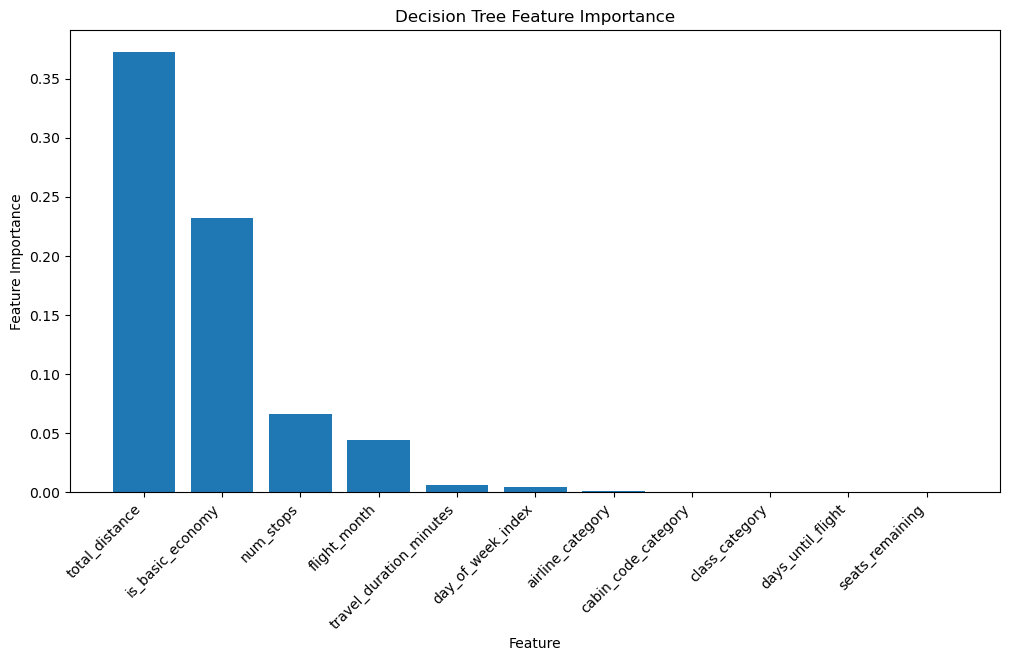

In [28]:
features = list(sorted_feature_importance.keys())
importances = list(sorted_feature_importance.values())

plt.figure(figsize=(12, 6))
plt.bar(features, importances)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=45, ha='right')

plt.show()

In [13]:
rf = RandomForestRegressor(featuresCol='features', labelCol='total_fare', numTrees=10)
rf_model = rf.fit(train_data)
rf_predictions_train = rf_model.transform(train_data)
rf_predictions_validation = rf_model.transform(validation_data)
rf_predictions_test = rf_model.transform(test_data)

In [14]:
gbt = GBTRegressor(featuresCol='features', labelCol='total_fare', maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions_train = gbt_model.transform(train_data)
gbt_predictions_validation = gbt_model.transform(validation_data)
gbt_predictions_test = gbt_model.transform(test_data)

In [15]:
glr = GeneralizedLinearRegression(featuresCol='features', 
                                  labelCol='total_fare', 
                                  family='gaussian', 
                                  link='identity', 
                                  maxIter=10)
glr_model = glr.fit(train_data)
glr_predictions_train = glr_model.transform(train_data)
glr_predictions_validation = glr_model.transform(validation_data)
glr_predictions_test = glr_model.transform(test_data)

23/11/28 17:12:09 WARN org.apache.spark.ml.util.Instrumentation: [40fab1b1] regParam is zero, which might cause numerical instability and overfitting.
23/11/28 17:12:35 WARN org.apache.spark.ml.util.Instrumentation: [40fab1b1] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [16]:
ridge = GeneralizedLinearRegression(featuresCol='features', 
                                    labelCol='total_fare', 
                                    predictionCol='prediction', 
                                    family='gaussian', 
                                    link='identity', 
                                    regParam=1.0, 
                                    linkPredictionCol='linkPrediction')
ridge_model = ridge.fit(train_data)
ridge_predictions_train = ridge_model.transform(train_data)
ridge_predictions_validation = ridge_model.transform(validation_data)
ridge_predictions_test = ridge_model.transform(test_data)

In [ ]:
rmse_evaluator = RegressionEvaluator(labelCol="total_fare", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="total_fare", predictionCol="prediction", metricName="r2")
mae_evaluator = RegressionEvaluator(labelCol="total_fare", predictionCol="prediction", metricName="mae")

models_classification = {
    "Linear Regression": {
        "model": lr_model,
        "predictions_train": lr_predictions_train,
        "predictions_validation": lr_predictions_validation,
        "predictions_test": lr_predictions_test
    },
    "Generalized Linear Regression": {
        "model": glr_model,
        "predictions_train": glr_predictions_train,
        "predictions_validation": glr_predictions_validation,
        "predictions_test": glr_predictions_test
    },
    "Ridge": {
        "model": ridge_model,
        "predictions_train": ridge_predictions_train,
        "predictions_validation": ridge_predictions_validation,
        "predictions_test": ridge_predictions_test
    },
    "Decision Trees": {
        "model": dt_model,
        "predictions_train": dt_predictions_train,
        "predictions_validation": dt_predictions_validation,
        "predictions_test": dt_predictions_test
    },
    "Random Forest": {
        "model": rf_model,
        "predictions_train": rf_predictions_train,
        "predictions_validation": rf_predictions_validation,
        "predictions_test": rf_predictions_test
    },
    "GBT": {
        "model": gbt_model,
        "predictions_train": gbt_predictions_train,
        "predictions_validation": gbt_predictions_validation,
        "predictions_test": gbt_predictions_test
    }
}

result_table = PrettyTable()
result_table.field_names = ["Model", "RMSE (Train)", "R2 (Train)", "MAE (Train)", "RMSE (Validation)", "R2 (Validation)", "MAE (Validation)", "RMSE (Test)", "R2 (Test)", "MAE (Test)"]

model_name_lst = []
r2_values_train = []
r2_values_validation = []
r2_values_test = []

for model_name, model_data in models_classification.items():

    # Evaluate the model on the training set
    rmse_train = rmse_evaluator.evaluate(model_data["predictions_train"])
    r2_train = r2_evaluator.evaluate(model_data["predictions_train"])
    mae_train = mae_evaluator.evaluate(model_data["predictions_train"])
    
    # Evaluate the model on the validation set
    rmse_validation = rmse_evaluator.evaluate(model_data["predictions_validation"])
    r2_validation = r2_evaluator.evaluate(model_data["predictions_validation"])
    mae_validation = mae_evaluator.evaluate(model_data["predictions_validation"])
    
    # Evaluate the model on the test set
    rmse_test = rmse_evaluator.evaluate(model_data["predictions_test"])
    r2_test = r2_evaluator.evaluate(model_data["predictions_test"])
    mae_test = mae_evaluator.evaluate(model_data["predictions_test"])

    model_name_lst.append(model_name)
    r2_values_train.append(r2_train)
    r2_values_validation.append(r2_validation)
    r2_values_test.append(r2_test)
    
    result_table.add_row([model_name, 
                          f"{rmse_train:.4f}", 
                          f"{r2_train:.4f}", 
                          f"{mae_train:.4f}", 
                          f"{rmse_validation:.4f}", 
                          f"{r2_validation:.4f}", 
                          f"{mae_validation:.4f}",
                          f"{rmse_test:.4f}", 
                          f"{r2_test:.4f}", 
                          f"{mae_test:.4f}"])

print(result_table)

+-------------------------------+--------------+------------+-------------+-------------------+-----------------+------------------+-------------+-----------+------------+
|             Model             | RMSE (Train) | R2 (Train) | MAE (Train) | RMSE (Validation) | R2 (Validation) | MAE (Validation) | RMSE (Test) | R2 (Test) | MAE (Test) |
+-------------------------------+--------------+------------+-------------+-------------------+-----------------+------------------+-------------+-----------+------------+
|       Linear Regression       |   104.4280   |   0.6999   |   76.2351   |      104.4663     |      0.6999     |     76.2510      |   104.3498  |   0.7003  |  76.1888   |
| Generalized Linear Regression |   104.4272   |   0.6999   |   76.2337   |      104.4676     |      0.6999     |     76.2503      |   104.3510  |   0.7003  |  76.1881   |
|             Ridge             |   104.4573   |   0.6997   |   76.2174   |      104.5030     |      0.6997     |     76.2351      |   104.3

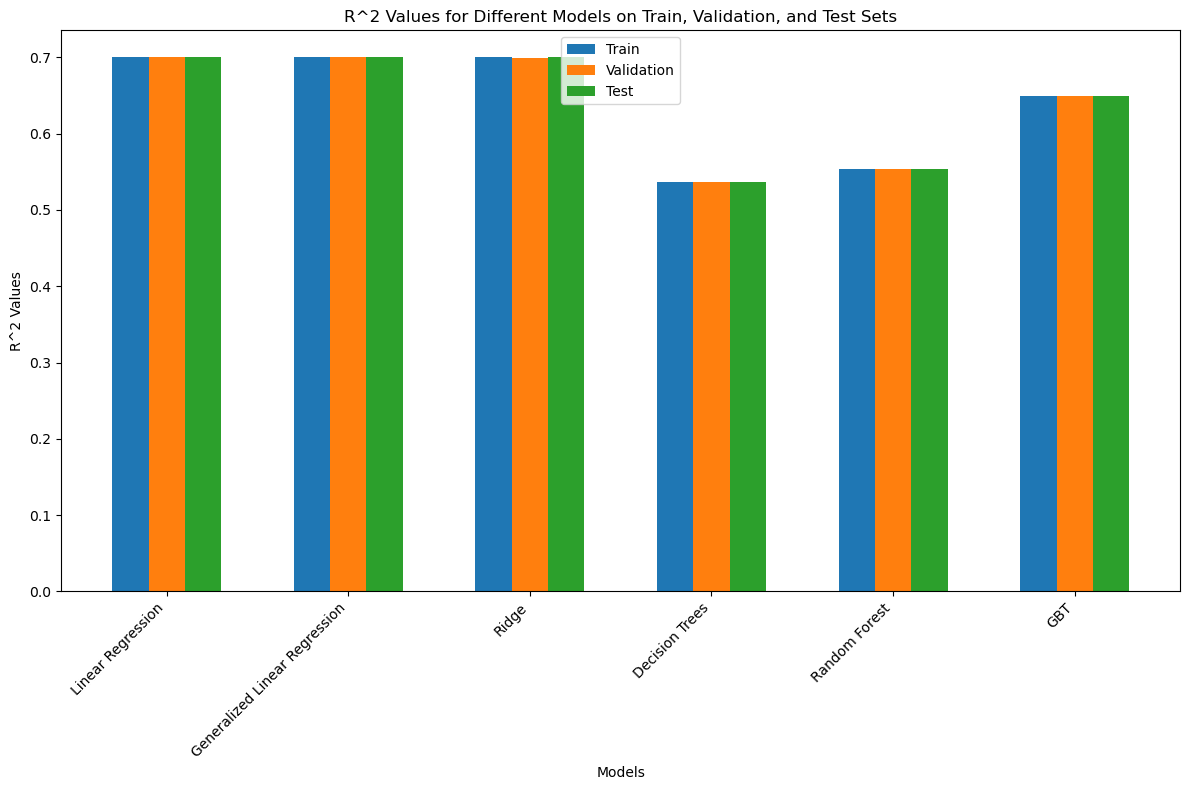

In [22]:
bar_positions = np.arange(len(model_name_lst))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(bar_positions - bar_width, r2_values_train, width=bar_width, label='Train')
ax.bar(bar_positions, r2_values_validation, width=bar_width, label='Validation')
ax.bar(bar_positions + bar_width, r2_values_test, width=bar_width, label='Test')

ax.set_xlabel('Models')
ax.set_ylabel('R^2 Values')
ax.set_title('R^2 Values for Different Models on Train, Validation, and Test Sets')
ax.set_xticks(bar_positions)
ax.set_xticklabels(model_name_lst, rotation=45, ha="right")  # Rotate x-tick labels
ax.legend()

plt.tight_layout()
plt.show()